# Use HRRR ZARR Dataset
By Lexie Goldberger and tutorial at https://mesowest.utah.edu/html/hrrr/

Files found here: https://hrrrzarr.s3.amazonaws.com/index.html

Another great resource for grabbing HRRR data via chunks for an area and plotting the forecast: https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/ex_python_plot_zarr.html

In [1]:
import s3fs
import xarray as xr
import pandas as pd
import numpy as np
import pyproj
import warnings
warnings.filterwarnings('ignore')

In [2]:
s3 = s3fs.S3FileSystem(anon=True)
def lookup(path):
    return s3fs.S3Map(path, s3=s3)

## Example 1
The types of use cases relevant for the Zarr archive require surface sensible weather parameters or meteorological parameters at "standard" levels in the vertical. Those are found in the sfc files bucket.

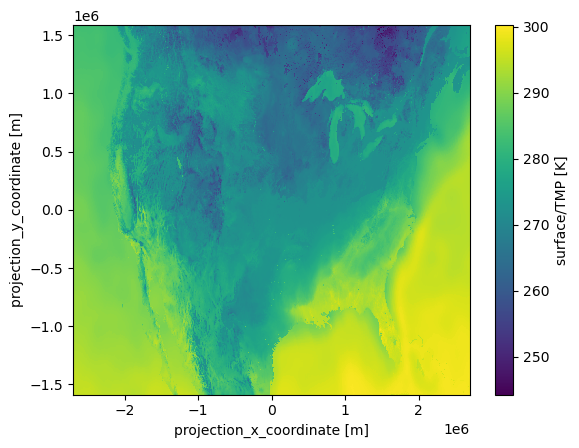

In [3]:
path = "hrrrzarr/sfc/20210101/20210101_00z_anl.zarr/surface/TMP"
ds = xr.open_mfdataset([lookup(path), lookup(f"{path}/surface")],engine="zarr") 
list(ds.keys())
ds.TMP.plot()

In [4]:
ds

<xarray.Dataset> Size: 4MB
Dimensions:                  (projection_x_coordinate: 1799,
                              projection_y_coordinate: 1059)
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 14kB -2.698e+0...
  * projection_y_coordinate  (projection_y_coordinate) float64 8kB -1.587e+06...
Data variables:
    forecast_period          timedelta64[ns] 8B ...
    forecast_reference_time  datetime64[ns] 8B ...
    height                   float64 8B ...
    pressure                 float64 8B ...
    time                     datetime64[ns] 8B ...
    TMP                      (projection_y_coordinate, projection_x_coordinate) float16 4MB dask.array<chunksize=(150, 150), meta=np.ndarray>

## Example 2
Applications that require meteorological parameters at all available levels will need to access the prs files bucket. 

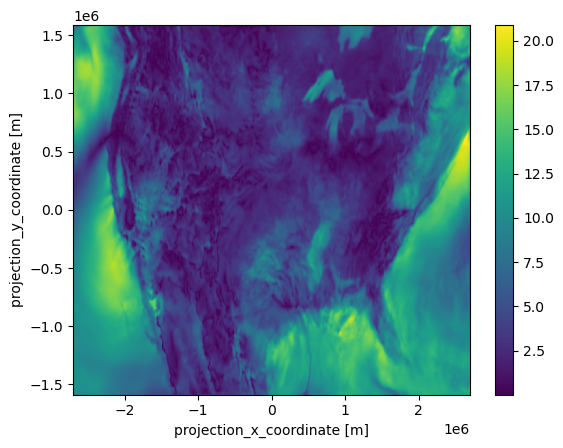

In [5]:
# Get wind data locations
base_path = "hrrrzarr/prs/20210101/20210101_00z_anl.zarr/1000mb"
v_path = f"{base_path}/VGRD"
u_path = f"{base_path}/UGRD"
# open data
ds_v = xr.open_mfdataset([lookup(v_path), lookup(f"{v_path}/1000mb")], engine="zarr")
ds_u = xr.open_mfdataset([lookup(u_path), lookup(f"{u_path}/1000mb")], engine="zarr")
# Calculate wind speed
wind_speed = np.sqrt(ds_u.UGRD**2 + ds_v.VGRD**2)
# Plot
wind_speed.plot()


## Example 3
Open files at each timestep and get mean

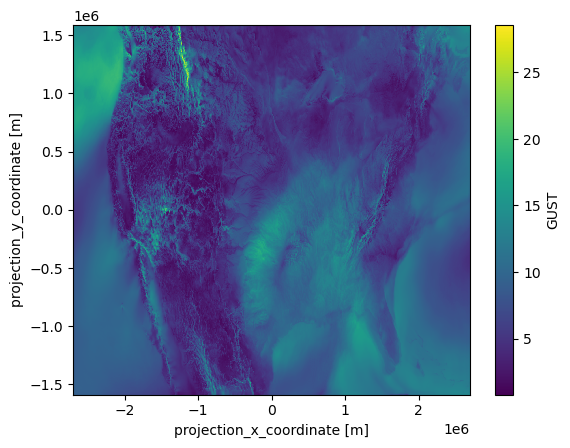

In [6]:
gust_arrays = []

for h in range(24):
    base_path = f"hrrrzarr/sfc/20210101/20210101_{str(h).zfill(2)}z_anl.zarr/surface/GUST"
    paths = [lookup(base_path), lookup(f"{base_path}/surface")]
    
    try:
        ds = xr.open_mfdataset(paths, engine="zarr")
        if "GUST" not in ds:
            print(f"Skipping hour {h}: 'GUST' not found.")
            continue
        
        gust = ds["GUST"]
        time_val = ds["time"].values
        gust = gust.expand_dims(time=[time_val])
        gust_arrays.append(gust)

    except Exception as e:
        print(f"Error reading hour {h}: {e}")
        continue

if gust_arrays:
    gust_all = xr.concat(gust_arrays, dim="time")
    mean_gust = gust_all.mean(dim="time")
    mean_gust.plot()
else:
    print("No valid GUST data found.")

In [8]:
# # Another way may be using chunks like

# # hrrrzarr/sfc/YYYYMMDD/YYYYMMDD_HHz_anl.zarr/surface/GUST

# def build_hrrr_paths(start_date="2021-01-01", end_date="2021-01-31", variable="GUST", level="surface"):
#     base_path = "hrrrzarr/sfc"
#     date_range = pd.date_range(start=start_date, end=end_date, freq="H")
#     paths = []
    
#     for dt in date_range:
#         day_str = dt.strftime("%Y%m%d")
#         hour_str = dt.strftime("%H")
#         path = f"{base_path}/{day_str}/{day_str}_{hour_str}z_anl.zarr/{level}/{variable}"
#         paths.append(path)
    
#     return paths

# # Generate all file paths for January 2021
# paths = build_hrrr_paths("2021-01-01", "2021-01-31")

# # Apply your `lookup()` function to each path
# zarr_stores = [lookup(p) for p in paths]

# # Open with Dask + xarray
# chunks = {
#     "time": min(100, chunksize_time),
#     "projection_y_coordinate": "auto",
#     "projection_x_coordinate": "auto"
# }

# import xarray as xr
# ds = xr.open_mfdataset(zarr_stores, engine="zarr", chunks=chunks, combine="by_coords")
    

## Example 4
Get histogram of gust data for a single time

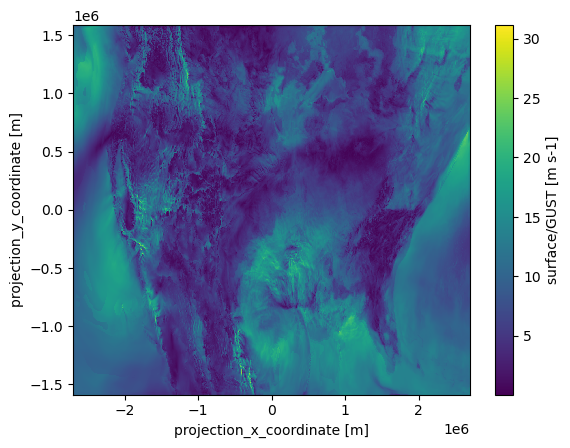

In [9]:
path = "hrrrzarr/sfc/20210101/20210101_00z_anl.zarr/surface/GUST"
ds = xr.open_mfdataset([lookup(path), lookup(f"{path}/surface")],engine="zarr") 
list(ds.keys())
ds.GUST.plot()

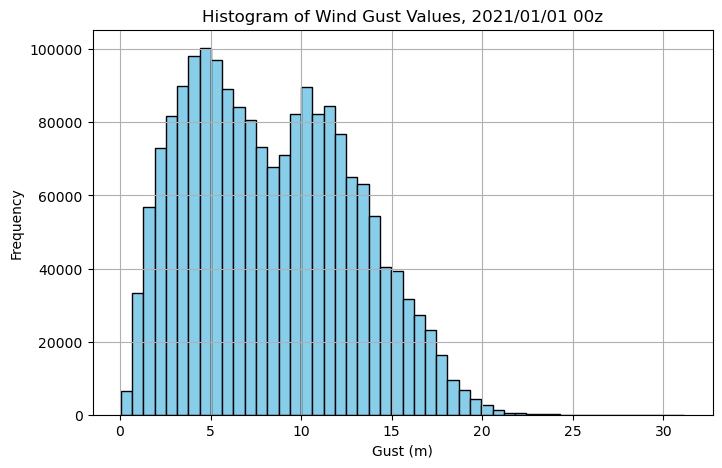

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Get the gust data as an xarray.DataArray
gust = ds["GUST"]

# If Dask-backed, compute it; otherwise, just use it
if hasattr(gust.data, "compute"):
    gust_values = gust.data.compute().flatten()
else:
    gust_values = gust.data.flatten()

# Drop NaNs
gust_values = gust_values[~np.isnan(gust_values)]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(gust_values, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Wind Gust Values, 2021/01/01 00z")
plt.xlabel("Gust (m)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# Convert Coordinates (Try 1)

In [ ]:
# Set up the coordinate transformation (EPSG:5070 for CONUS, EPSG:4326 for lat/lon)
proj_in = pyproj.CRS("EPSG:5070")  # Albers Equal Area
proj_out = pyproj.CRS("EPSG:4326")  # WGS 84 (lat/lon)
transformer = pyproj.Transformer.from_crs(proj_in, proj_out, always_xy=True)

# Get the x and y coordinates
x_coords = gust_all.coords['projection_x_coordinate'].values
y_coords = gust_all.coords['projection_y_coordinate'].values

# Meshgrid the coordinates (assuming they are 1D)
x_grid, y_grid = np.meshgrid(x_coords, y_coords)

# Flatten the grid to 1D arrays
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Transform the flattened x, y coordinates to lat/lon
lon_flat, lat_flat = transformer.transform(x_flat, y_flat)

# Reshape the transformed coordinates back into 2D grids matching the original shape
lon_grid = lon_flat.reshape(x_grid.shape)
lat_grid = lat_flat.reshape(y_grid.shape)

# Add new latitude and longitude coordinates to the dataset
gust_all.coords['longitude'] = (['projection_y_coordinate', 'projection_x_coordinate'], lon_grid)
gust_all.coords['latitude'] = (['projection_y_coordinate', 'projection_x_coordinate'], lat_grid)


In [ ]:
print(lon_grid[:5, :5], lat_grid[:5, :5])  # First few lat/lon values in the grid
print('this looks wrong')

In [ ]:
gust_all.isel(time=0).plot(x="longitude", y="latitude")


In [ ]:
print(gust_all.attrs)
print(gust_all.encoding)


In [ ]:
from pyproj import CRS

# Define HRRR native projection (Lambert Conformal Conic for CONUS)
proj_hrrr = CRS.from_proj4("+proj=lcc +lat_1=38.5 +lat_2=38.5 +lat_0=38.5 +lon_0=-97.5 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs")
proj_latlon = CRS("EPSG:4326")

transformer = pyproj.Transformer.from_crs(proj_hrrr, proj_latlon, always_xy=True)


In [ ]:
# Set up the coordinate transformation (EPSG:5070 for CONUS, EPSG:4326 for lat/lon)
proj_in = pyproj.CRS.from_proj4("+proj=lcc +lat_1=38.5 +lat_2=38.5 +lat_0=38.5 +lon_0=-97.5 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs")
proj_out = pyproj.CRS("EPSG:4326")  # WGS 84 (lat/lon)
transformer = pyproj.Transformer.from_crs(proj_in, proj_out, always_xy=True)

# Get the x and y coordinates
x_coords = gust_all.coords['projection_x_coordinate'].values
y_coords = gust_all.coords['projection_y_coordinate'].values

# Meshgrid the coordinates (assuming they are 1D)
x_grid, y_grid = np.meshgrid(x_coords, y_coords)

# Flatten the grid to 1D arrays
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Transform the flattened x, y coordinates to lat/lon
lon_flat, lat_flat = transformer.transform(x_flat, y_flat)

# Reshape the transformed coordinates back into 2D grids matching the original shape
lon_grid = lon_flat.reshape(x_grid.shape)
lat_grid = lat_flat.reshape(y_grid.shape)

# Add new latitude and longitude coordinates to the dataset
gust_all.coords['longitude'] = (['projection_y_coordinate', 'projection_x_coordinate'], lon_grid)
gust_all.coords['latitude'] = (['projection_y_coordinate', 'projection_x_coordinate'], lat_grid)


In [ ]:
gust_all.isel(time=0).plot(x="longitude", y="latitude")


## Convert Coordinates (Try 2)

In [14]:
#note I went into the easy environment and installed metpy with pip. It didn't brick :)

In [13]:
import metpy
import datetime
import cartopy.crs as ccrs

In [15]:
projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))

def load_dataset(urls):
    fs = s3fs.S3FileSystem(anon=True)
    ds = xr.open_mfdataset([s3fs.S3Map(url, s3=fs) for url in urls], engine='zarr')
    ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
    ds = ds.metpy.assign_crs(projection.to_cf())
    ds = ds.metpy.assign_latitude_longitude()
    ds = ds.set_coords("time")
    return ds
def load_combined_dataset(start_date, num_hours, level, param_short_name):
    combined_ds = None
    for i in range(num_hours):
        time = start_date + datetime.timedelta(hours=i)
        group_url = time.strftime(f"s3://hrrrzarr/sfc/%Y%m%d/%Y%m%d_%Hz_anl.zarr/{level}/{param_short_name}")
        subgroup_url = f"{group_url}/{level}"
        partial_ds = load_dataset([group_url, subgroup_url])
        if not combined_ds:
            combined_ds = partial_ds
        else:
            combined_ds = xr.concat([combined_ds, partial_ds], dim="time", combine_attrs="drop_conflicts")
    return combined_ds

In [16]:
%%time
ds = load_combined_dataset(datetime.datetime(2021, 4, 1), 24, "1000mb", "TMP")

CPU times: user 7.69 s, sys: 861 ms, total: 8.55 s
Wall time: 21 s


In [17]:
%%time
std_dev = ds.TMP.std(dim="time")
std_dev.values

CPU times: user 11.7 s, sys: 1.23 s, total: 13 s
Wall time: 15.1 s


array([[0.4177, 0.421 , 0.4177, ..., 0.324 , 0.324 , 0.324 ],
       [0.4238, 0.4238, 0.4177, ..., 0.324 , 0.324 , 0.324 ],
       [0.4238, 0.4238, 0.4238, ..., 0.324 , 0.324 , 0.324 ],
       ...,
       [0.5703, 0.5327, 0.5303, ..., 0.66  , 0.6846, 0.7656],
       [0.5703, 0.5254, 0.5327, ..., 0.782 , 0.799 , 0.789 ],
       [0.5464, 0.5254, 0.5254, ..., 0.803 , 0.8813, 0.8267]],
      shape=(1059, 1799), dtype=float16)

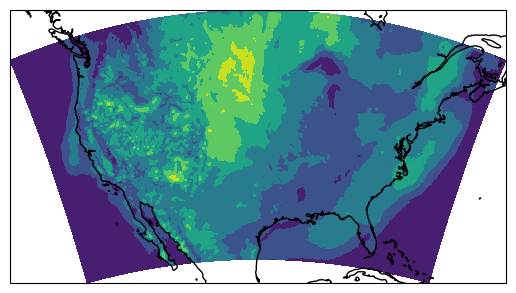

In [18]:
ax = plt.axes(projection=ccrs.Mercator())
ax.contourf(std_dev.x, std_dev.y, std_dev, transform=projection)
ax.coastlines()

plt.show()

In [27]:
da = std_dev

# Extract and rename 1D coordinates
lat_1d = xr.DataArray(da['latitude'][:, 0].values, dims='latitude')
lon_1d = xr.DataArray(da['longitude'][0, :].values, dims='longitude')

# Create a new DataArray with dimensions (latitude, longitude)
new_da = xr.DataArray(
    data=da.values,
    dims=('latitude', 'longitude'),
    coords={
        'latitude': lat_1d,
        'longitude': lon_1d
    },
    attrs=da.attrs
)

new_da

<xarray.DataArray (latitude: 1059, longitude: 1799)> Size: 4MB
array([[0.4177, 0.421 , 0.4177, ..., 0.324 , 0.324 , 0.324 ],
       [0.4238, 0.4238, 0.4177, ..., 0.324 , 0.324 , 0.324 ],
       [0.4238, 0.4238, 0.4238, ..., 0.324 , 0.324 , 0.324 ],
       ...,
       [0.5703, 0.5327, 0.5303, ..., 0.66  , 0.6846, 0.7656],
       [0.5703, 0.5254, 0.5327, ..., 0.782 , 0.799 , 0.789 ],
       [0.5464, 0.5254, 0.5254, ..., 0.803 , 0.8813, 0.8267]],
      shape=(1059, 1799), dtype=float16)
Coordinates:
  * latitude   (latitude) float64 8kB 21.14 21.16 21.19 ... 47.79 47.81 47.84
  * longitude  (longitude) float64 14kB -122.7 -122.7 -122.7 ... -72.32 -72.29

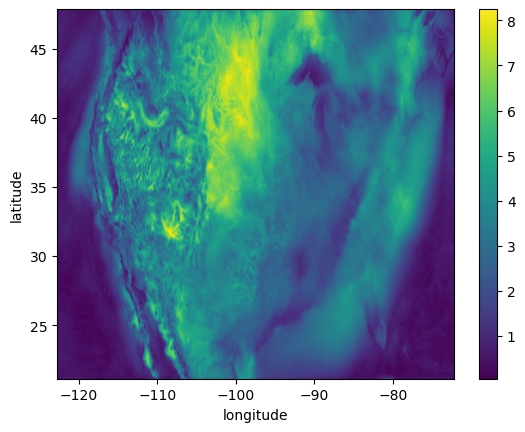

In [29]:
new_da.plot()

# HealPix Grid

In [31]:
import easygems.healpix as egh
import intake
from functools import partial

In [32]:
# List available catalogs
catalog_file = "https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml"

list(intake.open_catalog(catalog_file))

['EU', 'NCAR', 'NERSC', 'UK', 'online']

In [33]:
# Select a catalog for your location
current_location = "NERSC"
cat = intake.open_catalog(catalog_file)[current_location]
list(cat)

['ERA5',
 'JRA3Q',
 'MERRA2',
 'icon_d3hp003',
 'icon_ngc4008',
 'ifs_tco3999-ng5_rcbmf',
 'scream2D_hrly',
 'scream_lnd',
 'scream_ne120',
 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_glm_n1280_CoMA9_TBv1p2',
 'um_glm_n1280_GAL9',
 'um_glm_n2560_RAL3p3']

In [34]:
pd.DataFrame(cat["scream2D_hrly"].describe()["user_parameters"])

,name,description,type,allowed,default
0,zoom,zoom resolution of the dataset,int,"[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",2


In [36]:
signed_lon = True if np.min(new_da.longitude) < 0 else False
print(f"Mask lon coordinate has negative values: {signed_lon}")

Mask lon coordinate has negative values: True


In [37]:
%%time
# Get OLR/precip data from catalog
catalog_params = {'zoom': 9}  # Can have multiple parameters

# Note the use of **catalog_params to pass the parameters
ds_hp = cat['scream2D_hrly'](**catalog_params).to_dask()

# Add lat/lon coordinates to the DataSet.
# Set signed_lon=True for matching lat/lon DataSet with longitude -180 to +180
ds_hp = ds_hp.pipe(partial(egh.attach_coords, signed_lon=signed_lon))
ds_hp

CPU times: user 176 ms, sys: 72.9 ms, total: 249 ms
Wall time: 390 ms


<xarray.Dataset> Size: 238GB
Dimensions:   (time: 9457, cell: 3145728)
Coordinates:
  * time      (time) object 76kB 2019-08-01 00:00:00 ... 2020-09-01 00:00:00
    lat       (cell) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
    lon       (cell) float64 25MB 45.0 45.09 44.91 45.0 ... -44.91 -45.09 -45.0
    crs       int64 8B 0
  * cell      (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
Data variables:
    pr        (time, cell) float32 119GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
    rlut      (time, cell) float32 119GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
    ELEV      (cell) float32 13MB dask.array<chunksize=(4096,), meta=np.ndarray>
    LANDFRAC  (cell) float32 13MB dask.array<chunksize=(4096,), meta=np.ndarray>
Attributes: (12/22)
    Conventions:                  CF-1.8
    atm_initial_conditions_file:  /lustre/orion/cli115/world-shared/e3sm/inpu...
    averaging_frequency:          1
    averaging_frequency_units:    nhours
    averaging_type:               INSTANT
    case:                         cess-control.ne1024pg2_ne1024pg2.F2010-SCRE...
    ...                           ...
    product:                      model-output
    realm:                        atmos
    run_t0:                       2019-08-01-00000
    source:                       E3SM Atmosphere Model (EAMxx)
    topography_file:              /lustre/orion/cli115/world-shared/e3sm/inpu...
    username:                     noel

### Remap HRRR to healpix grid

In [38]:
# Assign extra coordinates (lon_hp, lat_hp) to the HEALPix coordinates
# This is needed for limiting the extrapolation during remapping
lon_hp = ds_hp.lon.assign_coords(cell=ds_hp.cell, lon_hp=lambda da: da)
lat_hp = ds_hp.lat.assign_coords(cell=ds_hp.cell, lat_hp=lambda da: da)
lat_hp

<xarray.DataArray 'lat' (cell: 3145728)> Size: 25MB
array([ 0.0746039 ,  0.14920793,  0.14920793, ..., -0.14920793,
       -0.14920793, -0.0746039 ], shape=(3145728,))
Coordinates:
    lat      (cell) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
    lon      (cell) float64 25MB 45.0 45.09 44.91 45.0 ... -44.91 -45.09 -45.0
    crs      int64 8B 0
  * cell     (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
    lat_hp   (cell) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
Attributes:
    units:          degree_north
    standard_name:  latitude
    axis:           Y

In [39]:
def fix_coords(ds, lat_dim="lat", lon_dim="lon", roll=False):
    """
    Fix coordinates in a dataset:
    1. Convert longitude from -180/+180 to 0-360 range (optional)
    2. Roll dataset to start at longitude 0 (optional)
    3. Ensure coordinates are in ascending order
    
    Parameters:
    -----------
    ds : xarray.Dataset or xarray.DataArray
        Dataset with lat/lon coordinates
    lat_dim : str, optional
        Name of latitude dimension, default "lat"
    lon_dim : str, optional
        Name of longitude dimension, default "lon"
    roll : bool, optional, default=False
        If True, convert longitude from -180/+180 to 0-360, and roll the dataset to start at longitude 0
        
    Returns:
    --------
    xarray.Dataset or xarray.DataArray
        Dataset with fixed coordinates
    """
    if roll:
        # Find where longitude crosses from negative to positive (approx. where lon=0)
        lon_0_index = (ds[lon_dim] < 0).sum().item()
        
        # Create indexers for the roll
        lon_indices = np.roll(np.arange(ds.sizes[lon_dim]), -lon_0_index)
        
        # Roll dataset and convert longitudes to 0-360 range
        ds = ds.isel({lon_dim: lon_indices})
        lon360 = xr.where(ds[lon_dim] < 0, ds[lon_dim] + 360, ds[lon_dim])
        ds = ds.assign_coords({lon_dim: lon360})
    
    # Ensure latitude and longitude are in ascending order if needed
    if np.all(np.diff(ds[lat_dim].values) < 0):
        ds = ds.isel({lat_dim: slice(None, None, -1)})
    if np.all(np.diff(ds[lon_dim].values) < 0):
        ds = ds.isel({lon_dim: slice(None, None, -1)})
    
    return ds

def is_valid(ds, tolerance=0.1):
    """
    Limit extrapolation distance to a certain tolerance.
    This is useful for preventing extrapolation of regional data to global HEALPix grid.

    Args:
        ds (xarray.Dataset):
            The dataset containing latitude and longitude coordinates.
        tolerance (float): default=0.1
            The maximum allowed distance in [degrees] for extrapolation.

    Returns:
        xarray.DataSet.
    """
    return (np.abs(ds.lat - ds.lat_hp) < tolerance) & (np.abs(ds.lon - ds.lon_hp) < tolerance)

In [40]:
new_da = new_da.rename({"longitude": "lon","latitude": "lat"})
# Apply function to fix MCS mask dataset coordinates
new_da.pipe(fix_coords)

<xarray.DataArray (lat: 1059, lon: 1799)> Size: 4MB
array([[0.4177, 0.421 , 0.4177, ..., 0.324 , 0.324 , 0.324 ],
       [0.4238, 0.4238, 0.4177, ..., 0.324 , 0.324 , 0.324 ],
       [0.4238, 0.4238, 0.4238, ..., 0.324 , 0.324 , 0.324 ],
       ...,
       [0.5703, 0.5327, 0.5303, ..., 0.66  , 0.6846, 0.7656],
       [0.5703, 0.5254, 0.5327, ..., 0.782 , 0.799 , 0.789 ],
       [0.5464, 0.5254, 0.5254, ..., 0.803 , 0.8813, 0.8267]],
      shape=(1059, 1799), dtype=float16)
Coordinates:
  * lat      (lat) float64 8kB 21.14 21.16 21.19 21.21 ... 47.79 47.81 47.84
  * lon      (lon) float64 14kB -122.7 -122.7 -122.7 ... -72.34 -72.32 -72.29

In [41]:
%%time
# Remap mask DataSet to HEALPix
new_da_hp = new_da.pipe(fix_coords).sel(lon=lon_hp, lat=lat_hp, method="nearest").where(partial(is_valid, tolerance=0.1))
# Drop unnecessary coordinates
new_da_hp = new_da_hp.drop_vars(["lat_hp", "lon_hp"])
new_da_hp

CPU times: user 402 ms, sys: 68.9 ms, total: 471 ms
Wall time: 491 ms


<xarray.DataArray (cell: 3145728)> Size: 6MB
array([nan, nan, nan, ..., nan, nan, nan], shape=(3145728,), dtype=float16)
Coordinates:
    lat      (cell) float64 25MB 21.14 21.14 21.14 21.14 ... 21.14 21.14 21.14
    lon      (cell) float64 25MB -72.29 -72.29 -72.29 ... -72.29 -72.29 -72.29
    crs      int64 8B 0
  * cell     (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727

### Visualize

Text(0.5, 1.0, 'HRRR healpix')

<Figure size 640x480 with 0 Axes>

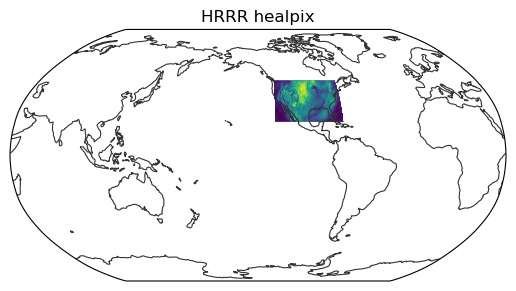

In [42]:
img = egh.healpix_show(new_da_hp)
plt.title("HRRR healpix")